# Plane Wave Fitting for Velocity Estimation
13th December,2021 

Author: Reet Mhaske

In [1]:
# importing the requiered libraries

import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import random


##### initialize no. of receivers, apparent horizontal velocity of sound, max frequency of source 

In [2]:

n_grp=10+2 # no. of receivers in a subset and not the number of subset
no_of_subsets=2
n_rec=n_grp*no_of_subsets #  ;number of receivers

rec_pos_act= np.zeros(shape =(n_rec,2))  # Assigning the actual receiver position

v = 2000 # m/s ### velocity of propagation (in sand)
freq=10 #Hz, max recorded frequency
lamda=v/freq# wavelength
d_limit=3000#m,  l=2000m  > 10 times lamda 

##### initialize position of source and  receivers 

In [3]:
#setting source configuration randomly
np.random.seed(0)
a=random.randint(int(d_limit-d_limit/10),d_limit*5) # source distance must be more than or equal to d , limits set here are arbitary within this acceptance
b=random.randint(int(d_limit-d_limit/10),d_limit*5)
src=(b,a)
random.randrange(d_limit-d_limit/10,d_limit*5)


#setting different receiver configurations

#uncomment following line for random distribution
rec_pos_act=np.random.normal(0,100,size=(n_rec,2))


#uncomment following line for linear distribution
for i in range(0,n_rec):
    rec_pos_act[i,1]=0
    rec_pos_act[i,0]=(i-(n_rec-1)/2)*5 #first receievr at (-50,0) last at (50,0), all in line, distance 5 between them 

#uncomment following line for circular distribution 

for i in range(0,int(n_rec/2)):
    rec_pos_act[i,0]=100*cos((2*i)*2*np.pi/(n_rec))
    rec_pos_act[int(i+n_rec/2),0]=100*cos((2*i+1)*2*np.pi/(n_rec))
    rec_pos_act[i,1]=100*sin((2*i)*2*np.pi/(n_rec))
    rec_pos_act[int(i+n_rec/2),1]=100*sin((2*i+1)*2*np.pi/(n_rec))
rec_pos_act[0]=(0,0)
rec_pos_act[int(n_rec/2)]=(0,0)




initialize time recordings by time of arrival, introduce noise in time and position

In [4]:


t_rec_ideal = np.zeros(shape =(n_rec,))  # time recorded in each receiver; form: (index of receiver,time) 


t_noise=np.random.normal(0,1/(v),size=(n_rec,))

#introduce noise in position
rec_pos_noise=np.random.normal(0,2.5,size=(n_rec,2))

rec_pos_mes= rec_pos_act + rec_pos_noise  # rec_pos_mes stores[(x1,y1),(x2,y2),..] 



#initialising time recordings

for i in range (0,n_rec):
    t_rec_ideal[0:n_rec] = np.sqrt((rec_pos_mes[0:n_rec,0]-src[0])**2 + (rec_pos_mes[0:n_rec,1]-src[1])**2)/v



### t_Rec_real has form [[rec1 recording], [rec2 recording]]

# introduce noise in time
t_Rec_real=t_rec_ideal + t_noise


# time difference between time recordings wrt receiver 1st rec, 
#in the form : time recorded by receiver at ith position - time recorded by 1st receiver 
t_diff=np.zeros(shape=(n_rec,))
for i in range(0,n_rec):
    t_diff[i]=t_rec_ideal[i]-t_rec_ideal[0]
    
   
    
    
    

We iterate over all values of the backazimuth $\phi$ such that it minimizes the error expression for 
N receivers:
$\hat{s} = \min_{s}\sum_{i=1}^{N} (\tau_{i} - r_{i}.s)^2 $
where i is the index of the receivers
$\tau_{i}$ is the time difference for $i^{th}$ receiver
where the slowness vector $\vec{s}$ is defined as:
$\vec{s} = (-\frac{\sin{\phi}}{v}, -\frac{\cos{\phi}}{v})$

In [5]:
#function to return the error expression for a particular s, v and given configuration of receivers : 

def sum_of_errors(s_x,s_y,n_rec,rec_loc,time_diff):
    ''' returns the error expression for particular  slowness vector s , apparent horizontal velocity v, receiver positions, and time differences\
        input s in form of s_x and s_y ( x and y coordinate ) \
        input n_rec: number of receivers \
        input rec_loc: 2-D array for receiver location , in form [(x_1,y_1),...(x_n_rec,y_n_rec)]\
        input time_diff: 1-D array for time difference [(t_i)]'''  
    soe=0 # sume of errors
    # find sum over all receivers
    for i in range (0,n_rec):
        soe+=(time_diff[i]-s_x*rec_loc[i,0]-s_y*rec_loc[i,1])**2
    return soe    

In [6]:
#function to estimate slowness by iterating over backazimuth

def estimate_backazimuth(v,n_rec,rec_loc,time_diff):
    ''' returns estimated backazimuth and final error for the estimated backazimuth\
    input v: apparent horizontal velocity\
    inputn_rec: number of receivers\
    input rec_loc: 2-D array for receiver locations in form [(x_1,y_2)]\
    input time_diff: 1-D array for time difference [(t_i)]'''
    phi_estimated=0
    error=10000
    phi_range = np.linspace(0,2*np.pi,200000)
    for phi in phi_range :
            soe=sum_of_errors(-np.sin(phi)/v,-np.cos(phi)/v,n_rec,rec_loc,time_diff)  
            #print(s_x_temp,s_y_temp)
            #print(soe)
            #print(s_x_temp,s_y_temp
            if ( error>soe):
                error =soe
                phi_estimated=phi
    if (sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)<error) :
        error=sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)
        phi_estimated=np.pi-phi_estimated
    return (phi_estimated,error)  

In [7]:

phi_actual=np.arctan2(src[0],src[1]) #y first for arctan2,rotate axis (N is x now), so input x first
if (phi_actual<0):
    phi_actual+=2*np.pi
d=v*t_Rec_real[0]              
print("actual angle: ", phi_actual)
phi_estimated,final_error=estimate_backazimuth(v,n_rec,rec_pos_mes,t_diff)
print("phi_estimated :",phi_estimated,"\nfinal_error: ", final_error)

print("pi- phi_estimated :",np.pi-phi_estimated)
print(" difference in backazimuth (diff of pi): ",np.pi-phi_estimated-phi_actual," percentage error : ",((np.pi-phi_estimated)/phi_actual-1)*100,"%"  )

print("difference in backazimuth: ",phi_estimated-phi_actual,"\npercentage error in backazimuth: ",((phi_estimated)/phi_actual-1)*100,"%"  )
print("diff in location: " ,  np.sqrt((src[0]-d*np.sin(phi_estimated))**2+(src[1]-d*np.cos(phi_estimated))**2))
print("diff in location (diff of pi): " ,  np.sqrt((src[0]-d*np.sin(np.pi-phi_estimated))**2+(src[1]-d*np.cos(np.pi-phi_estimated))**2))
print("percentage error in distance: ",(np.sqrt((src[0]-d*np.sin(phi_estimated))**2+\
                                               (src[1]-d*np.cos(phi_estimated))**2)/ np.sqrt(src[0]**2+src[1]**2) )*100,"%")

src_estimated_by_all=d*np.sin(phi_estimated),d*np.cos(phi_estimated)
print(src_estimated_by_all)
print(src)

actual angle:  0.8847008897305487
phi_estimated : 0.8853366523914015 
final_error:  1.7792443716691695e-06
pi- phi_estimated : 2.2562560011983916
 difference in backazimuth (diff of pi):  1.3715551114678428  percentage error :  155.03037550754294 %
difference in backazimuth:  0.0006357626608527456 
percentage error in backazimuth:  0.07186187650907172 %
diff in location:  6.155228718975286
diff in location (diff of pi):  11688.28087577997
percentage error in distance:  0.0666917462181923 %
(7143.275066172151, 5841.280654364769)
(7141, 5847)


In [8]:
x=np.linspace(0,2*np.pi,2000)
y=np.zeros(shape=(2000,))
for i in range(0,2000):
    y[i]=sum_of_errors(-sin(x[i])/v,-cos(x[i])/v,n_rec,rec_pos_mes,t_diff)

Text(0.5, 1.0, 'error vs backazimuth')

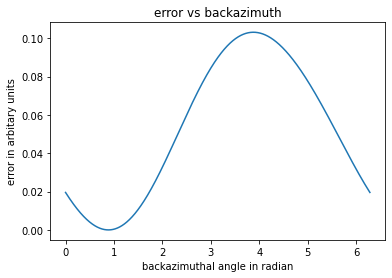

In [9]:
plt.plot(x,y)
plt.xlabel("backazimuthal angle in radian")
plt.ylabel("error in arbitary units")
plt.title("error vs backazimuth")

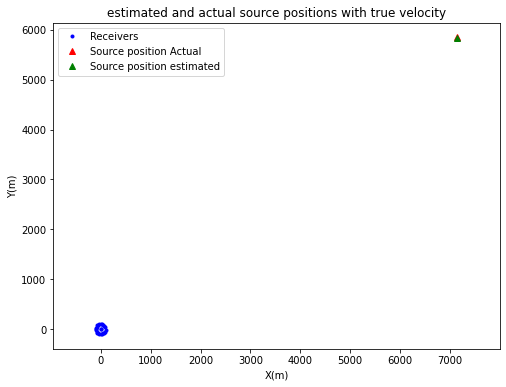

In [10]:
x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position



plt.figure(figsize=(8,6))
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(src[0],src[1],'r^',label='Source position Actual')
d=v*t_Rec_real[0]
plt.plot(d*np.sin(phi_estimated),d*np.cos(phi_estimated),'g^',label='Source position estimated')


plt.plot()
plt.legend()
#plt.xlim(-500,500)
#plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')

plt.title('estimated and actual source positions with true velocity')
plt.show()

     

Cause of the error is because the estimated position assumes that first receiver (at index 0) is at origin ,\\
whereas this is not the case for circular configuration

Configurations tried so far:
linear,
gaussian(negative results),
circular

Noise introduced in position has standard deviation 5m; and that in time has standard deviation 5/v

## Estimating Velocity

Code Above is same as the one for plane wave fitting for known velocity found here: https://github.com/Student-Satellite-IITB/GLEE/blob/Seismology-Payload/Beamforming/Plane%20Wave%20Fitting.ipynb \
The code starting hereafter is to estimate the velocity by iterating over all possibe values of velocity and then finding the velocity that minimizes the error in concurrency for the positions estimated by all receivers


In [11]:
def error_in_concurrency(v,n_rec,no_of_groups,n_in_this_grp,rec_loc,time,time_diff):
    '''For the input velocity v, no. of subgroups , no. of receivers in each subgroup, receiver locations, time recorings,/
    time difference, this function runs the plane wave fitting algorithm for each subset , generates /
    no_of_groups+1 estimates for receiver positions (the last one considering all receivers)/
    then finds the perimeter of the figure formed by al these points as an estimate of the error in concurrency/
    Returns ths error along with an array of the estimated receiver positions'''
    
    # this stores the positions estimated by each group
    estimates_of_src=np.zeros(shape=(no_of_groups+1,2))
    
    #iterating over the int("no_of_groups") groups
    for i in range(0,n_rec,n_in_this_grp):
        #print(i,i+n_in_this_grp)
        
        # new_rec_loc is an array containing receiver positions of the  group currently being considered 
        new_rec_loc=np.zeros(shape=(n_in_this_grp,2))
        
        #iitialize new_rec_loc with positions of receivers of the group being considered
        for k in range(0,n_in_this_grp):
            new_rec_loc[k][0]=rec_loc[k+i][0]#-rec_loc[i][0]
            new_rec_loc[k][1]=rec_loc[k+i][1]#-rec_loc[i][1]
        
        #finding the backazimuth estimated by this group
        phi,error=estimate_backazimuth(v,n_in_this_grp,new_rec_loc,time_diff[i:i+n_in_this_grp])
        
        #finding the position estimated by this group
        #distnace from the first receiver of this group
        d_i=v*time[i]
        
        #use these comments to debug 
        ##print(d_i)
        ##print(new_rec_loc)
        ##print("phi: ", phi)
        ##print("d_i*np.sin(phi): ",d_i*np.sin(phi),"d_i*np.cos(phi): ",d_i*np.cos(phi))
        ##print("rec_loc[i][0]+d_i*np.sin(phi): ",rec_loc[i][0]+d_i*np.sin(phi),"rec_loc[i][1]+d_i*np.cos(phi): ",rec_loc[i][1]+d_i*np.cos(phi))
        
        
        # finally estimating the position of source using the backazimuth and distance estimated by the considered group
        estimates_of_src[int(i/n_in_this_grp)]=(rec_loc[i][0]+d_i*np.sin(phi),rec_loc[i][1]+d_i*np.cos(phi))
    
    #so far, estimates_of_src has int("no_of_groups") estimated positions
    
      
    #now consider all receivers as one group   
    
    #backazimuth estimated by all receivers as one group
    phi_all,err= estimate_backazimuth(v,n_rec,rec_loc,time_diff) #err is just a place holder, phi_all is angle estimated by all receivers together   
    
    #distance from the first receiver of this group
    d_all=v*time[0]
    
    #estimating source position using backazimuth and distance estimated by all receivers as one group
    estimates_of_src[-1][0]=rec_loc[0][0]+d_all*np.sin(phi_all)
    estimates_of_src[-1][1]=rec_loc[0][1]+d_all*np.cos(phi_all)  
    
    
    # now estimates_of_src has int(no_of_groups+1) estimated positions
    
    # find perimeter of figure formed by these estimated points
    error_in_conc=0
    for j in range(0,no_of_groups+1):   
            error_in_conc+=np.sqrt((estimates_of_src[int(j)%int(no_of_groups)][0]-estimates_of_src[int(j+1)%int(no_of_groups)][0])**2\
    
                                + (estimates_of_src[int(j)%int(no_of_groups)][1]-estimates_of_src[int(j+1)%int(no_of_groups)][1])**2)
            
   # this perimeter is the error in concurrency 

    # return error in concurrency and positions estimated by each group
    return error_in_conc ,estimates_of_src      
    

In [12]:
def find_velocity(guessed_max=3010,guessed_min=1010,n_rec=1,no_of_groups=1,n_in_this_grp=1,rec_loc=(0,0),time=(0,0),time_diff=(0),step_size=20):
    '''Iterates over the range of velocity from guessed_min to guessed_max in steps of "step_size" , which is set default to 20 \
       the error in concurrenecy for each velocity is found using the function error_in_concurrency\
       the velocity that minimizes this error is returned as the estimated velocity'''
    # initialize a high error
    err=10000
    #velocity is the velocity estimated after running the function and is returned
    velocity=0
    
    #velocity range for iteration
    v_range=np.linspace(guessed_min,guessed_max,step_size)
    
    #erros_in_concurrency is the array that stores the errors for the corresponding velocity
    errors_in_concurrency=np.zeros(shape=(step_size,))
    
    #est is a 3D array, its ith element is the 2D array of positions estimated by the groups for the ith velocity 
    est=np.zeros(shape=(step_size,no_of_groups+1,2))
    
    #iterate over the velocity range
    #find the errors in concurrency
    for i in range(0,step_size):
        errors_in_concurrency[i],est[i]=error_in_concurrency(v_range[i],n_rec,no_of_groups,n_in_this_grp,rec_loc,time,time_diff)
        
    #plot the graph for error in concurrency vs velocity    
    plt.plot(v_range,errors_in_concurrency)
    plt.xlabel("velocity in m/s")
    plt.ylabel("error in concurrency in m")
    plt.title("error in concurrency vs velocity")
    plt.show()
    
    #find minimum error
    err=np.min(errors_in_concurrency)
    
    #return velocity corresponding to this minimum error
    velocity=guessed_min + (guessed_max-guessed_min)/interval* list(errors_in_concurrency).index(err)
    
   
    return velocity,est[list(errors_in_concurrency).index(err)],err       

Find a rough estimate of velocity by iterating in step size of 20 from 1010m/s to 3010m/s 

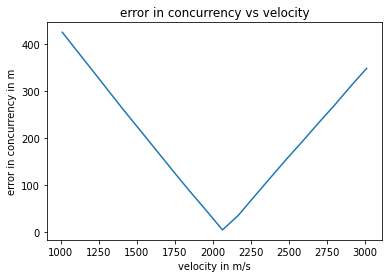

2010.0 [[7356.36530883 6037.53524606]
 [7356.39314286 6038.91774293]
 [7358.45236934 6034.99367973]]


In [14]:
vel_estimated,estimates,error=find_velocity(n_rec=n_rec,no_of_groups=no_of_subsets,n_in_this_grp=n_grp,rec_loc=rec_pos_mes,time=t_Rec_real,time_diff=t_diff)
print(vel_estimated,estimates)
#these errors are perimeters 

Now, that vel_estimated is the velocity estimated so far and estimates is the array of positions estimated by the groups error is the error in concurrency /
We make finer iterations for velocity by reducing the domain , which is centred about the previous estimated of velocity

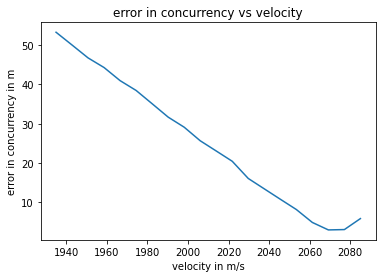

2062.5 [[7378.48718216 6058.42449196]
 [7378.90592226 6059.32432134]
 [7380.77180542 6055.64349711]]


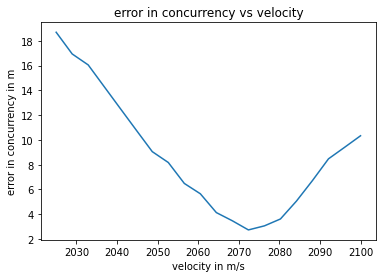

2070.0 [[7388.98046634 6068.60339858]
 [7389.78605411 6069.02918154]
 [7391.45958383 6065.58632888]]


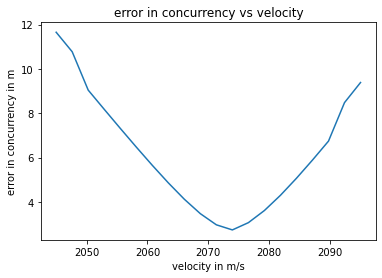

2072.5 [[7394.41709774 6073.46166559]
 [7395.22567362 6073.88213331]
 [7396.89819894 6070.44237511]]


In [17]:
for i in range(1,4):# the more the no, of iterations, the more finner step size and restricted domain of iteration
    vel_estimated,estimates,error=find_velocity(vel_estimated+(75/i),max(0,vel_estimated-(75/i)),n_rec=n_rec,no_of_groups=no_of_subsets,n_in_this_grp=n_grp,rec_loc=rec_pos_mes,time=t_Rec_real,time_diff=t_diff)
    print(vel_estimated,estimates)
#these errors are perimeters 

Now, we have vel_estimated storing the estimate of velocity that is used for backazimuth estimation

In [48]:
print("actual source position", src)
#print("src position estimated by all receivers: ",src_estimated_by_all)
print("estimated velocity: ",vel_estimated," m/s","\nactual velocity: ", v," m/s")
print("error in concurrency: ",error, "m")
print("estimates of source position: \n", estimates[0]," \n", estimates[1],"\n", estimates[2])
print("percentage error in velocity: ", ((vel_estimated-v)/v)*100," %")

mean_position_estimated=np.sum(estimates, axis=0)/3 # find mean position estimated
diff=np.sqrt(np.sum(np.square(mean_position_estimated-src))) # find distance in mean position and actual position
print("percentage error in source position: ", diff/np.sqrt(np.sum(np.square(src)))*100," % ")#np.sqrt(np.sum(np.square(src))) is the distance of source from origin

err_real_vel,estimates_real_velocity=error_in_concurrency(v,n_rec,no_of_subsets,n_grp,rec_pos_mes,t_Rec_real,t_diff)
print("error in concurrency with no error in velocity estimation : ", err_real_vel, "\nestimates of source positions with no error in velocity estimation:\n", estimates_real_velocity)

actual source position (7141, 5847)
estimated velocity:  2072.5  m/s 
actual velocity:  2000  m/s
error in concurrency:  2.7340981220541183 m
estimates of source position: 
 [7394.41709774 6073.46166559]  
 [7395.22567362 6073.88213331] 
 [7396.89819894 6070.44237511]
percentage error in velocity:  3.6249999999999996  %
percentage error in source position:  3.6850142055073873  % 
error in concurrency with no error in velocity estimation :  27.390054423928667 
estimates of source positions with no error in velocity estimation:
 [[7146.49057411 5837.74475083]
 [7141.46625504 5845.3679686 ]
 [7146.12356788 5838.19358981]]


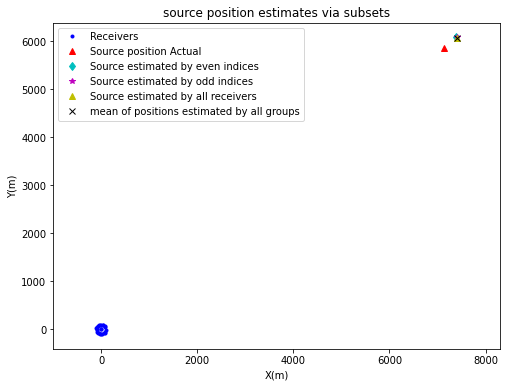

In [49]:
x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position

plt.figure(figsize=(8,6))
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(src[0],src[1],'r^',label='Source position Actual')

plt.plot(estimates[0][0],estimates[0][1],'cd',label='Source estimated by even indices')
plt.plot(estimates[1][0],estimates[1][1],'m*',label='Source estimated by odd indices')

plt.plot(estimates[2][0],estimates[2][1],'y^',label='Source estimated by all receivers')
#plt.plot(d*np.sin(np.pi-phi_estimated),d*np.cos(np.pi-phi_estimated),'g^',label='Source position estimated')
#plt.plot(d*np.sin(np.pi/2-phi_estimated),d*np.cos(np.pi/2-phi_estimated),'g^',label='Source position estimated')
plt.plot(mean_position_estimated[0],mean_position_estimated[1],'kx',label='mean of positions estimated by all groups')
plt.plot()
plt.legend()
#plt.xlim(-500,500)
#plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')

plt.title('source position estimates via subsets')
plt.show()


0.0

[[7394.41709774 6073.46166559 7395.22567362]
 [6073.88213331 7396.89819894 6070.44237511]]
